# Linear Regression Model Training
### Read in features and labels
### Do some multivariate linear regression
### See how good the fits are

In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

%matplotlib inline

In [2]:
# read in features and labels/examples (see build_features_labels2.ipynb for more info)
features = pd.read_csv('data_final/features.csv')
print features.shape
features[:10]

(314, 47)


,census_tract,bus_age,n_business,n_businesses_11,n_businesses_21,n_businesses_22,n_businesses_23,n_businesses_31,n_businesses_32,n_businesses_33,...,homes_percent_clear,homes_percent_rent,employment_percent,income_med,income_med_owner,income_med_renter,cost_med,cost_med_owner,cost_med_renter,total_amount
0,100,0.541876,0.040244,0.25,0.0,0.0,0.027027,0.000000,0.000,0.006757,...,0.231,0.180,0.372928,0.615612,0.499898,0.147354,0.513829,0.48075,0.9195,0.000000
1,201,0.538251,0.055183,0.00,0.0,0.0,0.032432,0.000000,0.000,0.006757,...,0.111,0.548,0.574586,0.566840,0.684250,0.227237,0.362798,0.56075,0.4870,0.021766
2,202,0.541876,0.055793,0.25,0.0,0.0,0.054054,0.000000,0.000,0.000000,...,0.095,0.578,0.654696,0.434022,0.417067,0.318495,0.422722,0.50650,0.7225,0.059047
3,300,0.486091,0.150000,0.25,0.0,0.0,0.037838,0.058824,0.025,0.027027,...,0.066,0.719,0.602210,0.356844,0.491126,0.270861,0.377983,0.57750,0.6410,0.357875
4,400,0.516499,0.146037,0.00,0.0,0.0,0.021622,0.029412,0.000,0.006757,...,0.034,0.844,0.660221,0.396237,0.347169,0.358638,0.352223,0.46750,0.6275,0.234442
5,500,0.449023,0.061280,0.00,0.0,0.0,0.027027,0.058824,0.000,0.000000,...,0.081,0.652,0.720994,0.317670,0.366111,0.265293,0.331887,0.45475,0.5725,0.011336
6,600,0.387541,0.076220,0.00,0.0,0.0,0.027027,0.029412,0.000,0.000000,...,0.066,0.701,0.689227,0.323496,0.349367,0.281653,0.329718,0.39675,0.5905,0.006188
7,700,0.446434,0.064939,0.25,0.0,0.0,0.032432,0.058824,0.025,0.006757,...,0.052,0.747,0.653315,0.399066,0.505572,0.327974,0.365239,0.60425,0.6205,0.062528
8,800,0.360758,0.040549,0.00,0.0,0.0,0.016216,0.000000,0.000,0.006757,...,0.055,0.712,0.613260,0.261325,0.401084,0.215931,0.296367,0.45200,0.5055,0.007590
9,900,0.264131,0.071341,0.00,0.0,0.0,0.016216,0.088235,0.050,0.006757,...,0.015,0.851,0.715470,0.266590,0.271528,0.229727,0.286334,0.45100,0.4975,0.016920


## Look for correlated features

## See if individual features are correlated w/ labels

NameError: name 'df_new' is not defined

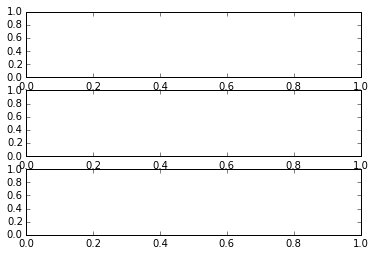

In [3]:
# plot features vs. score
fig, axs = plt.subplots(3,1, sharey=True)
df_new.plot(kind='scatter', x='Population', y='Score', ax=axs[0], figsize=(15, 18))
###axs[0].plot(pop, pop_preds, c='red', linewidth=2)
df_new.plot(kind='scatter', x='Employment_Percentage', y='Score', ax=axs[1])
df_new.plot(kind='scatter', x='Num_Homes', y='Score', ax=axs[2])

In [ ]:
# plot features vs. score
fig, axs = plt.subplots(3, 1, sharey=True)
df_new.plot(kind='scatter', x='Median_Age', y='Score', ax=axs[0], figsize=(15, 18))
df_new.plot(kind='scatter', x='Median_Housing_Cost', y='Score', ax=axs[1])
df_new.plot(kind='scatter', x='Median_Income', y='Score', ax=axs[2])

NameError: name 'df_new' is not defined

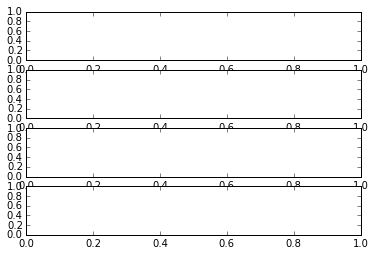

In [4]:
# plot features vs. score
fig, axs = plt.subplots(4, 1, sharey=True)
df_new.plot(kind='scatter', x='Population_Percent_Male', y='Score', ax=axs[0], figsize=(15, 18))
df_new.plot(kind='scatter', x='Population_Percent_Female', y='Score', ax=axs[1])
df_new.plot(kind='scatter', x='Num_Businesses', y='Score', ax=axs[2])
df_new.plot(kind='scatter', x='Num_Businesses_Code', y='Score', ax=axs[3])

## Fit w/ all input features (using statsmodels)

In [5]:
# fit the data
#   + to use feature
#   - to remove feature
#   : to multiply 2 features
#   * to multiply 2 features *and* use both individually
#   C(<feature>) to make <feature> into dummy/categorical feature
model = smf.ols(formula='bus_age ~ n_business + n_businesses_11 - n_businesses_21 - n_businesses_22 + n_businesses_23 +' \
             'n_businesses_31 + n_businesses_32 + n_businesses_33 + n_businesses_42 + n_businesses_44 +' \
             'n_businesses_45 + n_businesses_48 + n_businesses_49 + n_businesses_51 + n_businesses_52 +' \
             'n_businesses_53 + n_businesses_54 + n_businesses_55 + n_businesses_56 + n_businesses_61 +' \
             'n_businesses_62 + n_businesses_71 + n_businesses_72 + n_businesses_81 + n_businesses_92 +' \
             'population + population_percent_male + population_percent_female + age_med + age_med_male + '\
             'age_med_female + minor_percent + adult_percent + homes + homes_percent_mortgage + '\
             'homes_percent_clear + homes_percent_rent + employment_percent + income_med + income_med_owner + '\
             'income_med_renter + cost_med + cost_med_owner + cost_med_renter + total_amount', data=features).fit()
# print the coefficients
model.params

Intercept                   -7.703511e+10
n_business                  -3.173327e+01
n_businesses_11              1.641278e-02
n_businesses_23              2.067515e+00
n_businesses_31              1.377753e-01
n_businesses_32              1.695225e-01
n_businesses_33              1.436786e+00
n_businesses_42              2.400125e+00
n_businesses_44              2.852324e+00
n_businesses_45              4.804114e+00
n_businesses_48              1.911628e+00
n_businesses_49              6.406656e-01
n_businesses_51              3.575470e-01
n_businesses_52              5.730441e-01
n_businesses_53              1.535605e+00
n_businesses_54              9.187278e+00
n_businesses_55              2.635237e-01
n_businesses_56              1.447166e+00
n_businesses_61              5.460723e-01
n_businesses_62              2.576803e+00
n_businesses_71              7.150644e-01
n_businesses_72              1.785851e+00
n_businesses_81              5.538694e+00
n_businesses_92              3.537

In [6]:
# print a summary of the model
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                bus_age   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     2.416
Date:                Sun, 18 Sep 2016   Prob (F-statistic):           1.23e-05
Time:                        20:46:13   Log-Likelihood:                 231.82
No. Observations:                 314   AIC:                            -377.6
Df Residuals:                     271   BIC:                            -216.4
Df Model:                          42                                         
=============================================================================================
                                coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------
Intercept                 -7.704e+10   2.95e+10     -2.610      0.010     -1.35e+11 -1.89e+10
n_business                  -31.7333     72.441     -0.438      0.662      -174.353   110.886
n_businesses_11               0.0164      0.105      0.156      0.876        -0.190     0.223
n_businesses_23               2.0675      4.148      0.498      0.619        -6.099    10.234
n_businesses_31               0.1378      0.754      0.183      0.855        -1.346     1.621
n_businesses_32               0.1695      1.066      0.159      0.874        -1.929     2.269
n_businesses_33               1.4368      3.318      0.433      0.665        -5.095     7.969
n_businesses_42               2.4001      5.774      0.416      0.678        -8.967    13.767
n_businesses_44               2.8523      6.322      0.451      0.652        -9.594    15.299
n_businesses_45               4.8041     11.038      0.435      0.664       -16.927    26.535
n_businesses_48               1.9116      4.078      0.469      0.640        -6.116     9.939
n_businesses_49               0.6407      1.595      0.402      0.688        -2.500     3.782
n_businesses_51               0.3575      1.321      0.271      0.787        -2.243     2.958
n_businesses_52               0.5730      1.885      0.304      0.761        -3.138     4.284
n_businesses_53               1.5356      3.751      0.409      0.683        -5.850     8.921
n_businesses_54               9.1873     19.035      0.483      0.630       -28.288    46.663
n_businesses_55               0.2635      0.419      0.629      0.530        -0.562     1.089
n_businesses_56               1.4472      3.192      0.453      0.651        -4.836     7.731
n_businesses_61               0.5461      1.529      0.357      0.721        -2.465     3.557
n_businesses_62               2.5768      5.521      0.467      0.641        -8.292    13.446
n_businesses_71               0.7151      1.667      0.429      0.668        -2.567     3.997
n_businesses_72               1.7859      5.414      0.330      0.742        -8.872    12.444
n_businesses_81               5.5387     11.296      0.490      0.624       -16.700    27.778
n_businesses_92               0.0354      0.060      0.590      0.556        -0.083     0.153
population                   -0.2411      0.160     -1.503      0.134        -0.557     0.075
population_percent_male    7.704e+10   2.95e+10      2.610      0.010      1.89e+10  1.35e+11
population_percent_female  7.704e+10   2.95e+10      2.610      0.010      1.89e+10  1.35e+11
age_med                       1.6803      2.109      0.797      0.426        -2.473     5.833
age_med_male                 -0.7134      1.229     -0.580      0.562        -3.134     1.707
age_med_female               -1.0030      1.027     -0.976      0.330        -3.026     1.020
minor_percent                -5.7583      8.798     -0.654  

0.406566919325
0.407529830933
0.070765118648


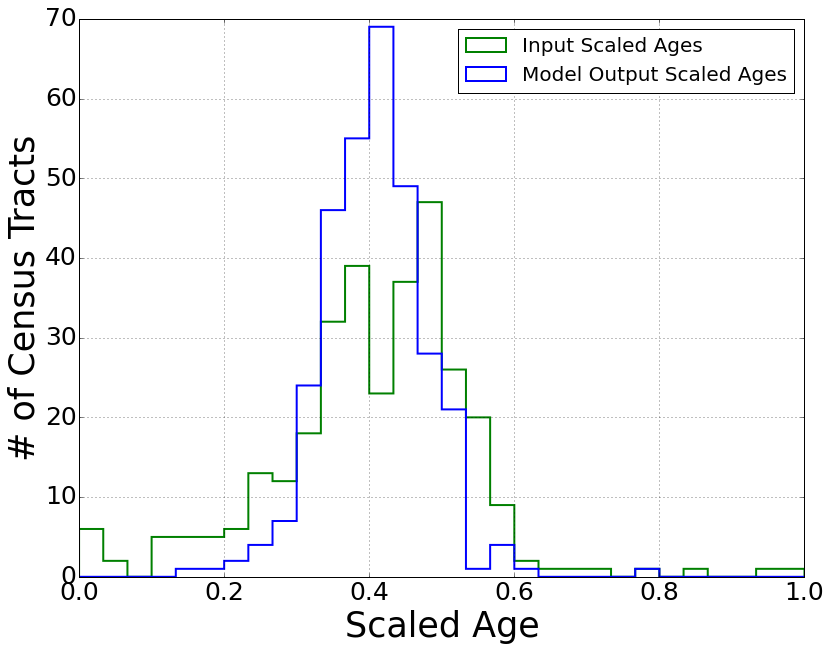

In [7]:
# save just scaled business ages out of dataframe
bus_age = features.bus_age.values

# use coefficients to calculate scaled ages for each census tract
bus_age_pred = model.predict(features)

# make histogram of scaled ages input and output
plt.figure(figsize=(13, 10))
plt.hist([bus_age_pred,bus_age], bins=30, histtype='step', align='mid', linewidth=2, \
         label=['Model Output Scaled Ages','Input Scaled Ages'])
plt.legend(loc=0,fontsize=20)
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=25)
plt.xlabel('Scaled Age',fontsize=35)
plt.ylabel('# of Census Tracts',fontsize=35)

# print some stats about model output
print np.mean(bus_age_pred)
print np.median(bus_age_pred)
print np.std(bus_age_pred)

In [8]:
# read in min/max values for each feature
minmax = pd.read_csv('data_final/min_max_features.csv',index_col=0)
minmax

,bus_age,n_business,n_businesses_11,n_businesses_21,n_businesses_22,n_businesses_23,n_businesses_31,n_businesses_32,n_businesses_33,n_businesses_42,...,homes_percent_clear,homes_percent_rent,employment_percent,income_med,income_med_owner,income_med_renter,cost_med,cost_med_owner,cost_med_renter,total_amount
min_max,,,,,,,,,,,,,,,,,,,,,
max_vals,1.0,3281.0,4.0,1.0,8.0,185.0,34.0,40.0,148.0,264.0,...,100.0,100.0,100.0,172846.0,230179.0,188750.0,3688.0,4000.0,2000.0,191205635.0
min_vals,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,27.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# define list of simple NAICS business codes
codes = [11,21,22,23,31,32,33,42,44,45,48,49,51,52,53,54,55,56,61,62,71,72,81,92]

# initialize lists of tracts, codes, and final predicted ages
tracts_final = np.ndarray(0)
codes_final = np.ndarray(0)
bus_age_pred_final = np.ndarray(0)

# go through each code
for code in codes:
    # reset new features dataframe
    new_features = features.copy()
    
    # save min/max of total business count
    temp_min = minmax.loc['min_vals']['n_business']
    temp_max = minmax.loc['max_vals']['n_business']
    # unscale total business count
    temp_n_bus = new_features['n_business'] * (temp_max-temp_min) + temp_min
    # increment total business count
    temp_n_bus += 1
    # rescale and save new total business count
    new_features['n_business'] = (temp_n_bus-temp_min) / (temp_max-temp_min)
    
    # save min/max of current code business count
    temp_min = minmax.loc['min_vals']['n_businesses_'+str(code)]
    temp_max = minmax.loc['max_vals']['n_businesses_'+str(code)]
    # unscale total business count
    temp_n_bus = new_features['n_businesses_'+str(code)] * (temp_max-temp_min) + temp_min
    # increment total business count
    temp_n_bus += 1
    # rescale and save new total business count
    new_features['n_businesses_'+str(code)] = (temp_n_bus-temp_min) / (temp_max-temp_min)

    # make predictions for this code for all tracts
    bus_age_pred = model.predict(new_features)
    
    # update lists of tracts, codes, and final predicted ages
    tracts_final = np.concatenate((tracts_final,new_features.census_tract.values))
    codes_final = np.concatenate((codes_final,[code]*len(bus_age_pred)))
    bus_age_pred_final = np.concatenate((bus_age_pred_final,bus_age_pred))

In [10]:
# check stuff that will be saved
print tracts_final.shape
#tracts_final[:400]
print codes_final.shape
#codes_final[:400]
print bus_age_pred_final.shape
#bus_age_pred_final[:400]

(7536,)
(7536,)
(7536,)


0.406209552142
0.406217575073
0.0710690390769


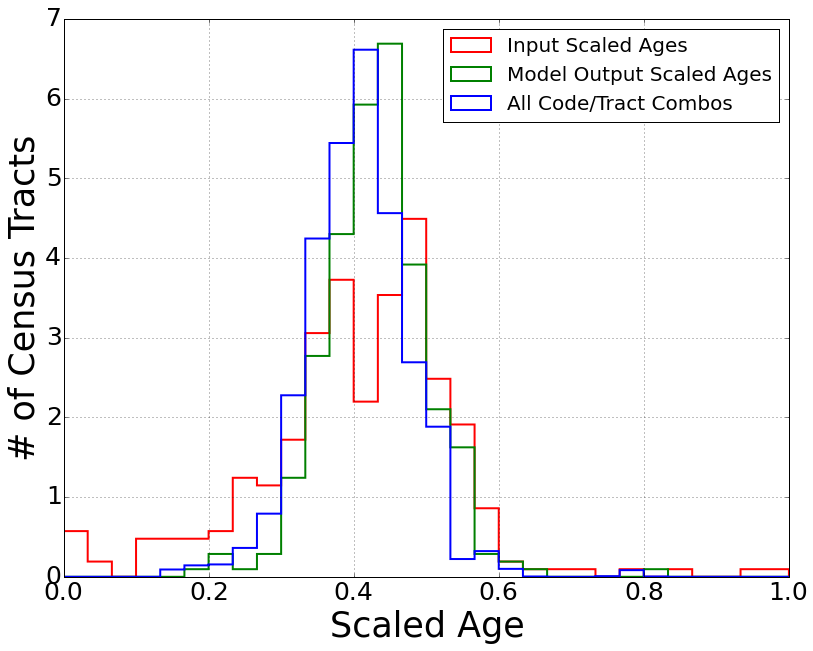

In [11]:
# make histogram of scaled ages input and output and final output (for each business/tract combo)
plt.figure(figsize=(13, 10))
plt.hist([bus_age_pred_final,bus_age_pred,bus_age], bins=30, histtype='step', align='mid', linewidth=2, normed=1, \
         label=['All Code/Tract Combos','Model Output Scaled Ages','Input Scaled Ages'])
plt.legend(loc=0,fontsize=20)
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=25)
plt.xlabel('Scaled Age',fontsize=35)
plt.ylabel('# of Census Tracts',fontsize=35)

# print some stats about model output
print np.mean(bus_age_pred_final)
print np.median(bus_age_pred_final)
print np.std(bus_age_pred_final)

//anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


39.5753917971
39.5766215086
10.8930778872


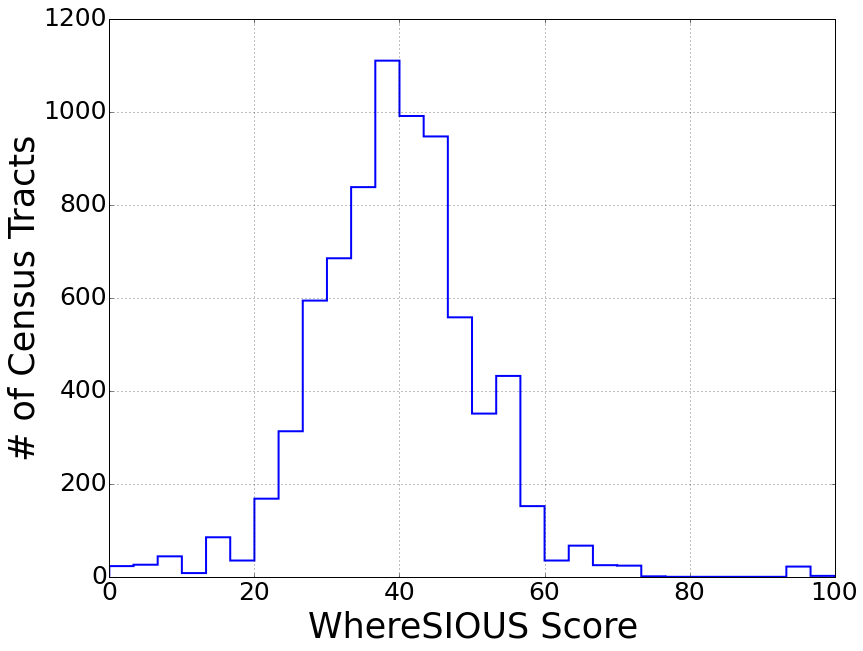

In [12]:
# scale ages to be WhereSIOUS scores between 0 and 100
scores = (bus_age_pred_final-min(bus_age_pred_final)) / (max(bus_age_pred_final)-min(bus_age_pred_final)) * 100

# make histogram WhereSIOUS scores
plt.figure(figsize=(13, 10))
plt.hist(scores, bins=30, histtype='step', align='mid', linewidth=2)
plt.legend(loc=0,fontsize=20)
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=25)
plt.xlabel('WhereSIOUS Score',fontsize=35)
plt.ylabel('# of Census Tracts',fontsize=35)

# print some stats about model output
print np.mean(scores)
print np.median(scores)
print np.std(scores)

In [13]:
# save lists of tracts, codes, and final predicted ages as a dataframe
df_out = pd.DataFrame({'census_tract': tracts_final, 'code_simple': codes_final, 'score': scores})
print df_out.shape
df_out[:520]

(7536, 3)


,census_tract,code_simple,score
0,100.0,11.0,47.682557
1,201.0,11.0,43.665986
2,202.0,11.0,44.475498
3,300.0,11.0,55.208766
4,400.0,11.0,42.038485
5,500.0,11.0,49.001924
6,600.0,11.0,44.903496
7,700.0,11.0,36.451128
8,800.0,11.0,40.017775
9,900.0,11.0,34.637401


In [14]:
# write dataframe of tracts, codes, and scores to csv in data_final folder and in flask static folder
df_out.to_csv('data_final/tracts_codes_scores.csv')
df_out.to_csv('wheresious/static/tracts_codes_scores.csv')

In [15]:
# test reading in dataframe of tracts, codes, and scores
temp = pd.read_csv('data_final/tracts_codes_scores.csv',index_col=0)
print temp.shape
temp[:10]

# test looking up a score given a tract and code
tract = 9104
code = 21
# get correct row of dataframe
score_row = temp[(temp.census_tract==tract) & (temp.code_simple==code)].score
# get score itself
score = score_row.values[0]
# format score to one decimal place
result = '{:.1f}'.format(score)
print result

(7536, 3)
53.7
